In [1]:
import os
import pickle

from PIL import Image
import numpy as np
from sklearn import metrics
from joblib import load
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize

n_classes = 4

def load_data(name, bmi=False):
    X_path = f'../data/processed/face_bmi_X_{name}.pkl'
    with open(X_path, 'rb') as f:
        X = pickle.load(f)
    if bmi:
        y_path = f'../data/processed/face_bmi_y_bmi_{name}.pkl'
    else:
        y_path = f'../data/processed/face_bmi_y_{name}.pkl'
    with open(y_path, 'rb') as f:
        y = pickle.load(f)
    return X, y

def digitize(arr):
    return np.digitize(arr, bins=[18.5, 25., 30])

def roc(bin_y, bin_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(bin_y[:, i], bin_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes
    return fpr, tpr, roc_auc

X_train, y_train = load_data('train', bmi=True)
X_test, y_test = load_data('test', bmi=True)
checkpoint_path = '../models/svm/final_svr.joblib'
svr = load(checkpoint_path)
preds_train = svr.predict(X_train)
preds_test = svr.predict(X_test)
cat_preds_train = digitize(preds_train)
cat_y_train = digitize(y_train)
cat_preds_test = digitize(preds_test)
cat_y_test = digitize(y_test)
bin_y_train = label_binarize(cat_y_train, classes=range(n_classes))
bin_pred_train = label_binarize(cat_preds_train, classes=[0, 1, 2, 3])
bin_y_test = label_binarize(cat_y_test, classes=range(n_classes))
bin_pred_test = label_binarize(cat_preds_test, classes=[0, 1, 2, 3])

## Regression Evaluation
Computes maximum error and mean absolute error on both the train and test set using the regression SVM model.

In [2]:
print('Regression metrics:')
for dset, labels, pred in [('train', y_train, preds_train),
                           ('test', y_test, preds_test)]:
    print('dataset:', dset)
    for metric in [metrics.max_error, metrics.mean_absolute_error]:
        print(metric.__name__, metric(labels, pred))
    print()

Regression metrics:
dataset: train
max_error 25.516539950859627
mean_absolute_error 2.001514282537395

dataset: test
max_error 15.614928077473998
mean_absolute_error 2.0366733264306327



## Classification Evaluation
Computes accuracy and confusion matrix after converting regression predictions into BMI categories.

Confusion matrix is formatted as follows:

|        |   |               |               |               |               |
|--------|---|---------------|---------------|---------------|---------------|
|        |   | Predictions   |               |               |               |
|        |   | 0             | 1             | 2             | 3             |
| Labels | 0 | Correct       | Misclassified | Misclassified | Misclassified |
|        | 1 | Misclassified | Correct       | Misclassified | Misclassified |
|        | 2 | Misclassified | Misclassified | Correct       | Misclassified |
|        | 3 | Misclassified | Misclassified | Misclassified | Correct       |

In [3]:
print('Classification metrics:')
for dset, labels, pred in [('train', cat_y_train, cat_preds_train), ('test', cat_y_test, cat_preds_test)]:
    print('dataset:', dset)
    cat_metrics = [metrics.accuracy_score, metrics.confusion_matrix]
    for metric in cat_metrics:
        print(metric.__name__,'\n',metric(labels, pred))
    print()

Classification metrics:
dataset: train
accuracy_score 
 0.7391304347826086
confusion_matrix 
 [[  3  10   3   0]
 [  0 360 111   0]
 [  0  47 349   1]
 [  0   4 112 104]]

dataset: test
accuracy_score 
 0.6991869918699187
confusion_matrix 
 [[ 0  2  0  0]
 [ 0 37 15  1]
 [ 0  5 40  0]
 [ 0  1 13  9]]



## ROC Curves
ROC curves are plotted after converting labels and predictions into BMI categories.

ROC is computed for each class seperately, resulting in four ROC curves per graph. Area under the graph is computed and shown in the legend.

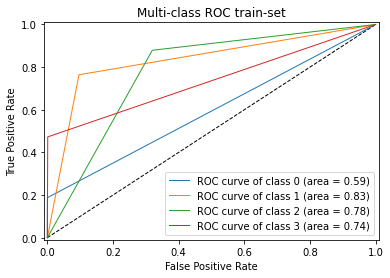

In [4]:
fpr_train, tpr_train, roc_auc_train = roc(bin_y_train, bin_pred_train)
plt.plot([0, 1], [0, 1], 'k--', lw=1)

for i in range(n_classes):
    plt.plot(fpr_train[i], tpr_train[i], lw=1,
             label=f'ROC curve of class {i} (area = {roc_auc_train[i]:0.2f})')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC train-set')
plt.legend(loc="lower right")
plt.show()

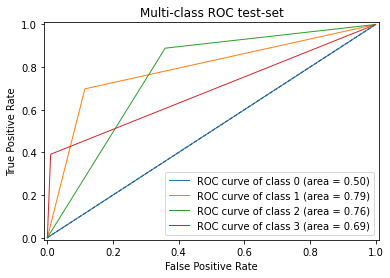

In [5]:
fpr_test, tpr_test, roc_auc_test = roc(bin_y_test, bin_pred_test)

plt.plot([0, 1], [0, 1], 'k--', lw=1)

for i in range(n_classes):
    plt.plot(fpr_test[i], tpr_test[i], lw=1,
             label=f'ROC curve of class {i} (area = {roc_auc_test[i]:0.2f})')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC test-set')
plt.legend(loc="lower right")
plt.show()